<a href="https://colab.research.google.com/github/k3larra/generalisation/blob/pc/shapes_XAI_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating model generalisation on basic shapes
This code accompanies the paper with the title "Deep Learning, generalisation and concepts".

This code uses a number of XAI methods to produce saliency maps. Models trained on basic shapes are used and the results compared. The discussion especially addresses question on generalisation and if the trained networks generalisation can be compared to human genralisation.

# Setup

In [1]:
!pip install matplotlib==3.5.3 #Used since captum uses this version to produce images.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [1]:
import os
import csv
import json
import shutil
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from os import listdir
from os.path import isfile, join
from PIL import Image
import matplotlib.pyplot as plt
from zipfile import ZipFile
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2.0.1+cu118


In [ ]:
!pip uninstall matplotlib

In [2]:
import matplotlib
matplotlib.__version__

'3.5.3'

In [ ]:
# # #Cleaning if needed
! rm -r models
#! rm -r generalisation
#! rm -r testset
# ! rm classes.txt

In [3]:
%%capture
#Get testset, training information and classes
! git clone https://github.com/k3larra/generalisation
with ZipFile('generalisation/testset/testset.zip', 'r') as archive:
  archive.extractall('testset')
f = open("generalisation/models/models.json")
models = json.load(f)
f.close()
with open("generalisation/classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
num_classes = len(categories)

def label_to_idx(label):
  return categories.index(label)

def idx_to_label(idx):
  return categories[idx]

## Dataloader


In [4]:
# create the annotation file for the tests!
shape_path = "/content/testset"
with open(shape_path + '/shapes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir(shape_path):
        if(dirs.endswith(".csv")):
            continue
        for f in listdir(join(shape_path, dirs)):
            if(join(shape_path, dirs, f).endswith(".csv")):
                continue
            elif isfile(join(shape_path, dirs, f)):
                writer.writerow([join(dirs, f), dirs])

# XAI Methods


In [5]:
%%capture
! pip install captum
from captum.attr import Occlusion
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution
from captum.attr import visualization as viz
sign="positive"

In [6]:
def calculate_layered_gradcam(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path=""):
  json_data = {}
  test_name='efficientnet_v2_s' #Needs to be changed to match model names (Ugly I know, I will change).
  input_img.requires_grad = True
  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)
  if test_name == 'resnet_50':
    layer_gradcam = LayerGradCam(experiment_model, experiment_model.layer4[2].conv3)
  elif test_name == 'efficientnet_v2_s':
    print('efficientnet_v2_s')
    layer_gradcam = LayerGradCam(experiment_model, experiment_model.features[-1])
  elif test_name == 'inception_v3':
    print('inception_v3')
    layer_gradcam = LayerGradCam(experiment_model, experiment_model.Mixed_7c.branch_pool.conv)
  elif test_name == 'efficientnet_b0':
    print('efficientnet_b0')
    layer_gradcam = LayerGradCam(experiment_model, experiment_model.features.conv)
  else:
    print('no layer')
  attributions = layer_gradcam.attribute(input_img, target=target_label)
  attributions = LayerAttribution.interpolate(attributions, input_img.shape[2:])
  input_img = input_img.squeeze()
  n=str(img_index)
  if sign=="positive":
    if torch.max(attributions)<0:
      json_data["error"]="no saliency map can be produced, only negative values in attributions"
    else:
      try:
        result = viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                input_img.cpu().permute(1,2,0).detach().numpy(),
                                method="blended_heat_map",
                                sign=sign,
                                fig_size=(5,5))
        result[0].savefig(save_path+n+ '_GradCam.PNG',bbox_inches='tight')
      except:
        json_data["error"]="no saliency map can be produced, Cannot normalize by scale factor = 0"
  json_data["image_path"] = save_path+n+'_GradCam.PNG'
  print("GradCam",target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))
  return json_data

In [7]:
def calculate_occlusion(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path=""):
  json_data = {}
  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)
  occlusion = Occlusion(experiment_model)
  attributions = occlusion.attribute(input_img,
                                   strides = (1, 30, 30),
                                   sliding_window_shapes=(1,30,30),
                                   #strides = (3, 8, 8),
                                   #sliding_window_shapes=(3,15,15),
                                   target=target_label,
                                   baselines = 0)
  input_img = input_img.squeeze()
  n=str(img_index)
  if sign=="positive":
    if torch.max(attributions)<0:
      json_data["error"]="no saliency map can be produced, only negative values in attributions"
    else:
      try:
        result = viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                              input_img.cpu().permute(1,2,0).detach().numpy(),
                              method="blended_heat_map",
                              sign=sign,
                              fig_size=(5,5))
        result[0].savefig(save_path+n+ '_Occlusion.PNG',bbox_inches='tight')
      except:
        json_data["error"]="no saliency map can be produced, Cannot normalize by scale factor = 0"
  json_data["image_path"] = save_path+n+ '_Occlusion.PNG'
  print("Occlusion",target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))
  return json_data

# Helpers

In [8]:
#Here additions are needed to use tranforms native for the models
#Image transformation
eval_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((299, 299)),
    ])

def transform_eval_data(img_path, eval_transform = None):
  image = Image.open(img_path).convert('RGB')
  if eval_transform:
      image = eval_transform(image)
  image = image.float()
  return image


In [9]:
def get_all_files(experiment_path):
  loaded_files = []
  for f in sorted(os.listdir(experiment_path)):
    if f.endswith('.PNG') or f.endswith('.png'):
      loaded_files.append(f)
  return loaded_files

def load_experiment_data(experiment_path):
  experiment_set = []
  eval_dir = get_all_files(experiment_path)
  eval_size = len(eval_dir)
  for i in range(eval_size):
    experiment_set.append(transform_eval_data(experiment_path + eval_dir[i],eval_transform))
  return experiment_set

In [10]:
def process_input(input_img, experiment_model):
  input_img = input_img.to(device)
  output = experiment_model(input_img)
  probabilities = F.softmax(output[0], dim=0)
  top_prob, top_catid = torch.topk(probabilities, num_classes)
  jsonData={}
  for i in range(top_prob.size(0)):
      prediction={}
      prob=top_prob[i].item()
      prediction["probability"] = np.round(top_prob[i].item(),3)
      if top_catid[i].item()<top_catid.size(0):
        prediction["label"] = idx_to_label(top_catid[i])
        prediction["labelid"] = top_catid[i].item()
      jsonData[i]=prediction
  return top_catid, top_prob, jsonData

## Study


In [11]:
def run_experiment_shapes(experiment_model, experiment_path, save_path, experiment_name, label_id=0):
  experiment_set = load_experiment_data(os.path.join(experiment_path, ''))
  #print("------------------")
  path_to_save = os.path.join(save_path + experiment_name, '')
  if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
  json_data = {}
  json_data["title"]=(experiment_name.split('/'))[2]
  json_data["unixtime"] = time.time()
  json_data["datetime"] = time.asctime( time.localtime(time.time()))
  json_data["description"] = "To be added"
  json_data["testset"] = "https://github.com/k3larra/generalisation/tree/pc/testset"
  for idx, experiment_sample in enumerate(experiment_set):
    plt.axis("off")
    plt.imsave(path_to_save+str(idx)+ '_Transfomed.PNG',experiment_sample.cpu().permute(1,2,0).detach().numpy())
    plt.imshow(experiment_sample.permute(1,2,0))
    experiment_sample = experiment_sample.unsqueeze(0)
    top_candidates, top_probs, jdata = process_input(experiment_sample, experiment_model)
    json_data[idx] = jdata
    json_data[idx]["gradcam"] = calculate_layered_gradcam(experiment_model,
                     target_label=top_candidates[label_id].item(),
                     input_img=experiment_sample,
                     top_candidates=top_candidates, top_probs=top_probs,
                     img_index=idx, save_path=path_to_save)

    json_data[idx]["occlusion"] = calculate_occlusion(experiment_model,
                            target_label=top_candidates[label_id],
                            input_img=experiment_sample,
                            top_candidates=top_candidates, top_probs=top_probs,
                            img_index=idx, save_path=path_to_save)
    j_data = {}
    j_data["image_path"] = path_to_save+str(idx)+ '_Transfomed.PNG'
    json_data[idx]["transformed"] = j_data
  return json_data

# Experiments!

generalisation/models/6ffe9788-8300-4727-997a-a1919c82d835_complete_model.pth : 6ffe9788-8300-4727-997a-a1919c82d835 : study1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


efficientnet_v2_s


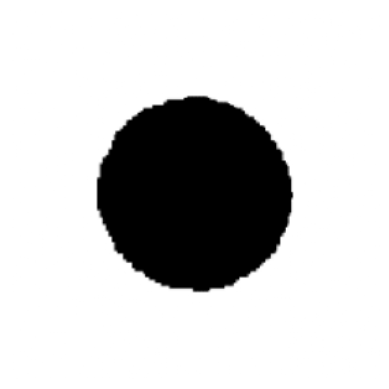

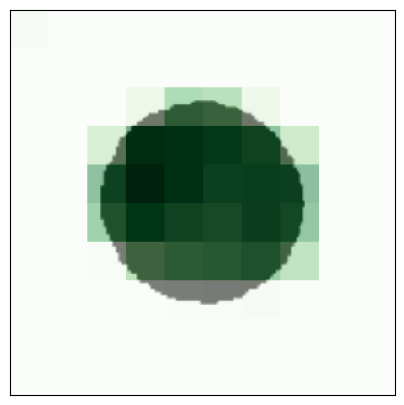

GradCam 0 circle 1.0


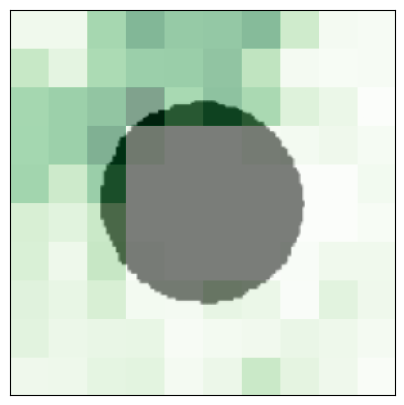

Occlusion tensor(0, device='cuda:0') circle 1.0
efficientnet_v2_s


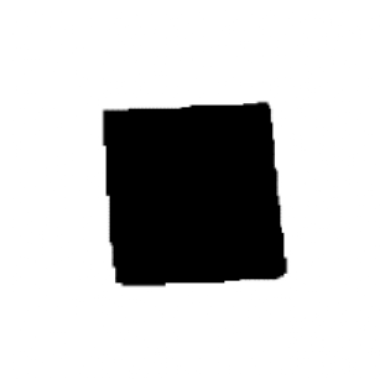

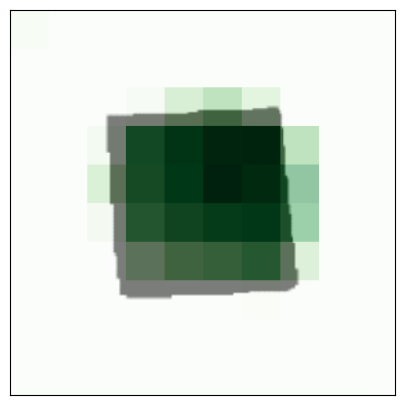

GradCam 1 square 1.0


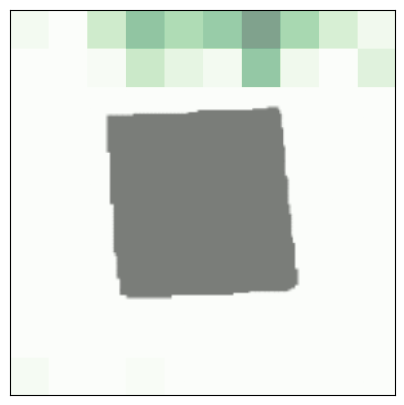

Occlusion tensor(1, device='cuda:0') square 1.0
efficientnet_v2_s


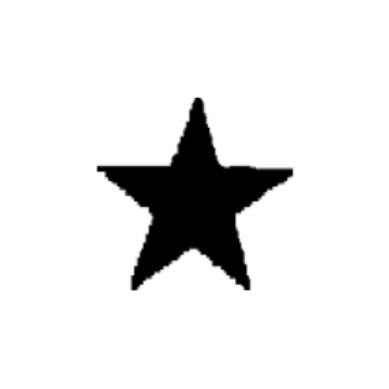

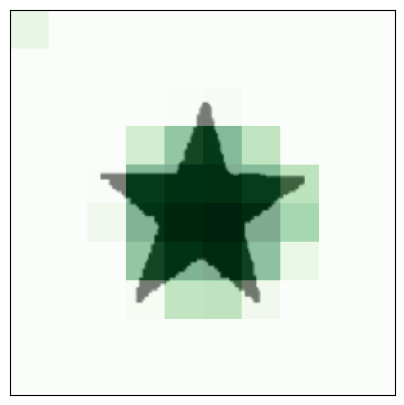

GradCam 2 star 1.0


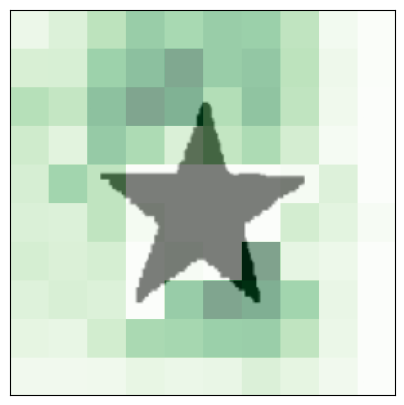

Occlusion tensor(2, device='cuda:0') star 1.0
efficientnet_v2_s


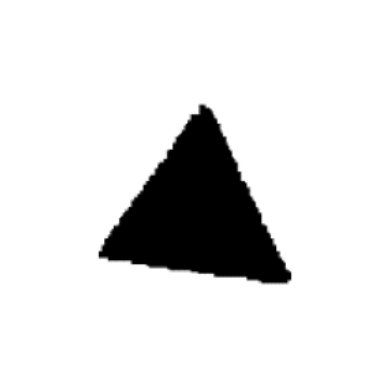

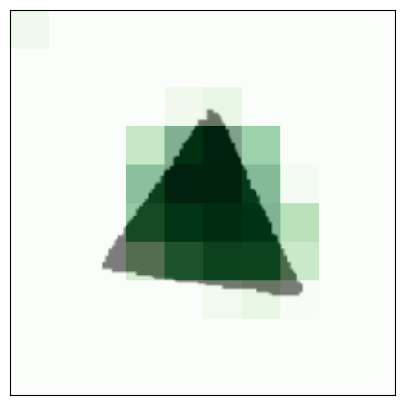

GradCam 3 triangle 1.0


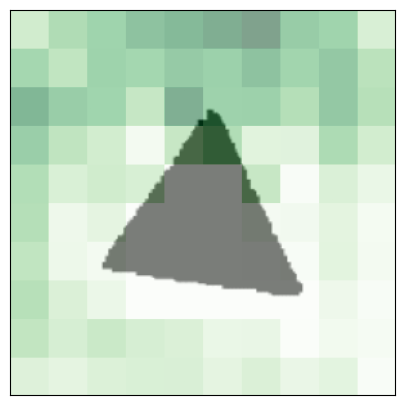

Occlusion tensor(3, device='cuda:0') triangle 1.0
efficientnet_v2_s


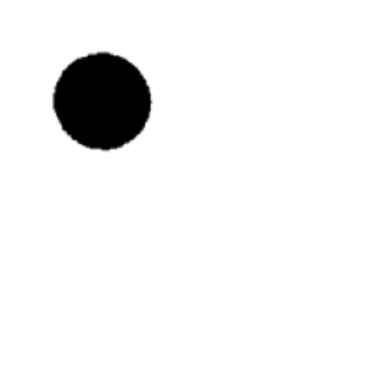

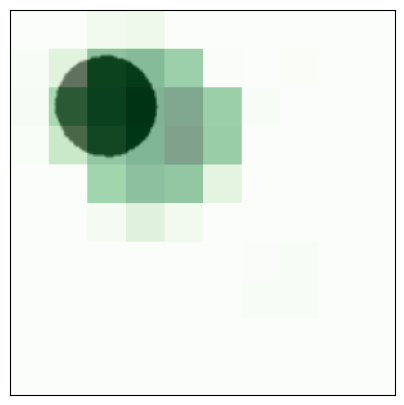

GradCam 0 circle 1.0


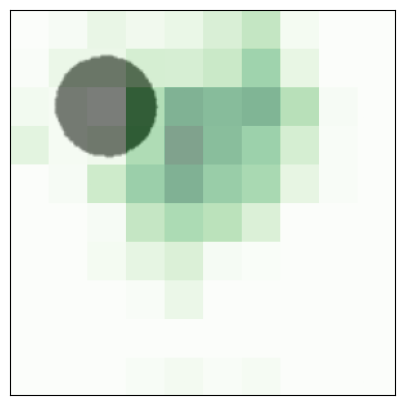

Occlusion tensor(0, device='cuda:0') circle 1.0
efficientnet_v2_s


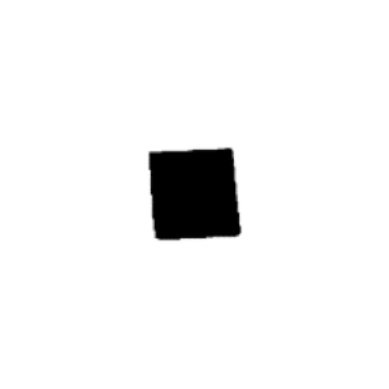

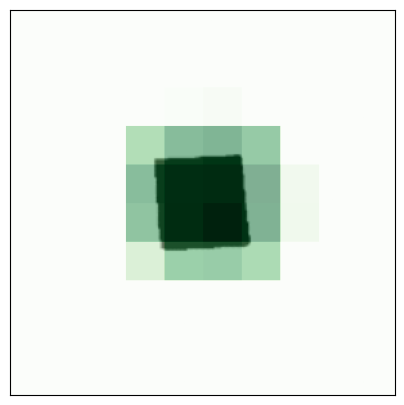

GradCam 1 square 1.0


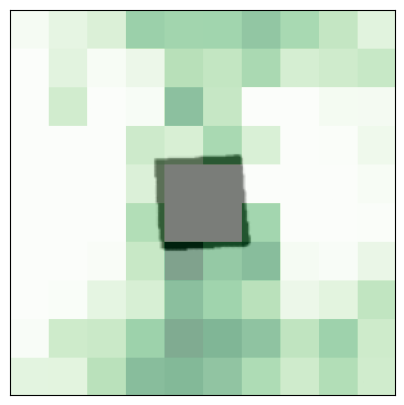

Occlusion tensor(1, device='cuda:0') square 1.0
efficientnet_v2_s


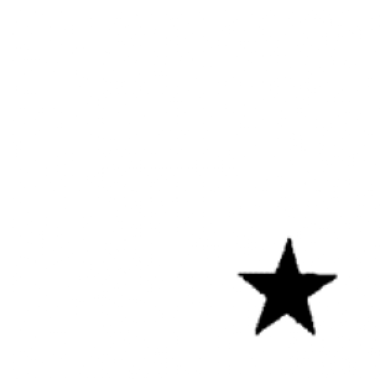

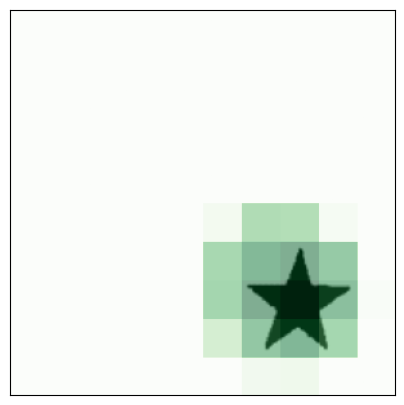

GradCam 2 star 1.0


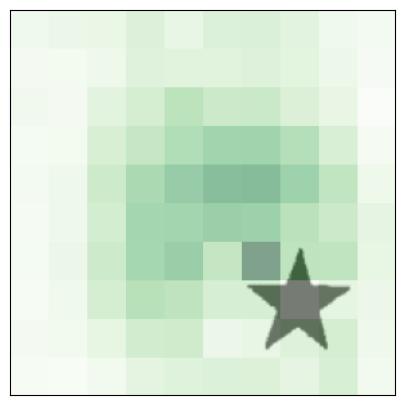

Occlusion tensor(2, device='cuda:0') star 1.0
efficientnet_v2_s


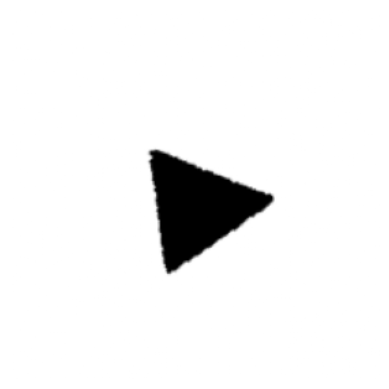

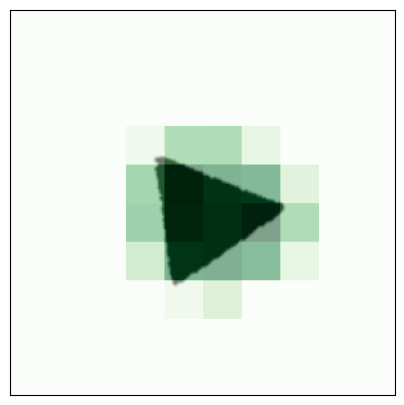

GradCam 3 triangle 1.0


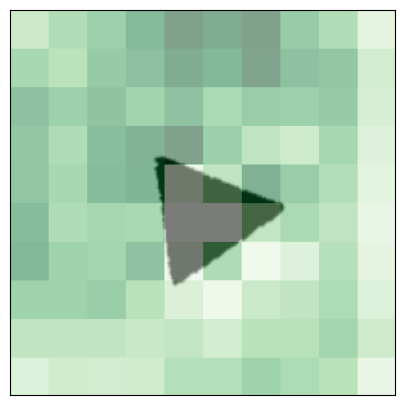

Occlusion tensor(3, device='cuda:0') triangle 1.0
generalisation/models/6ffe9788-8300-4727-997a-a1919c82d835_complete_model.pth : 6ffe9788-8300-4727-997a-a1919c82d835 : study2
efficientnet_v2_s


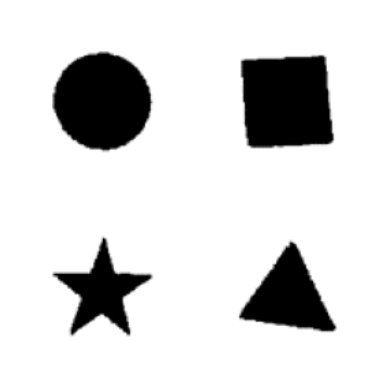

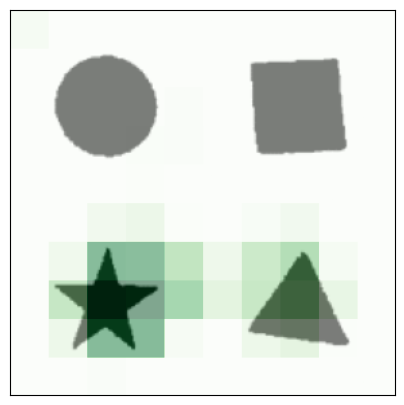

GradCam 2 star 0.56


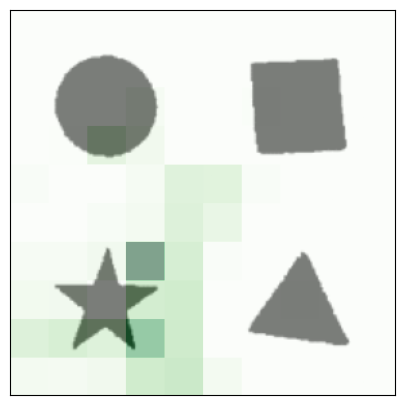

Occlusion tensor(2, device='cuda:0') star 0.56
efficientnet_v2_s


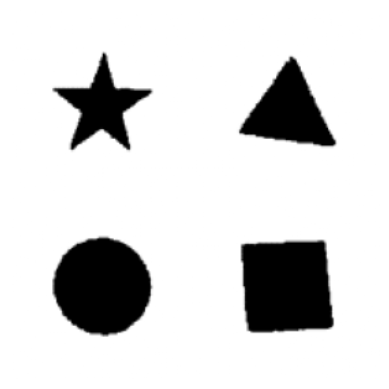

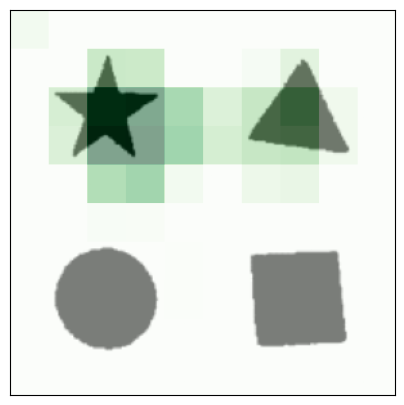

GradCam 2 star 0.71


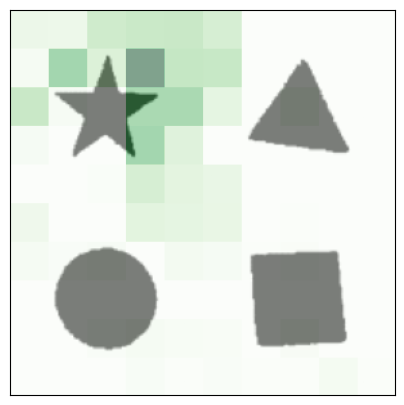

Occlusion tensor(2, device='cuda:0') star 0.71
efficientnet_v2_s


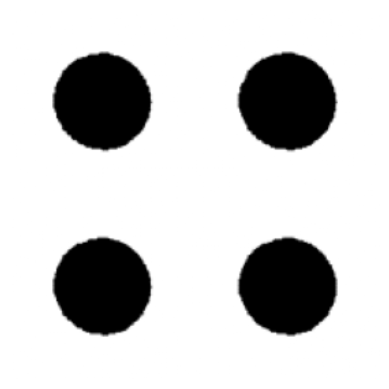

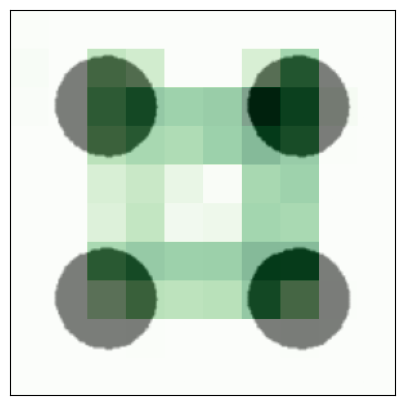

GradCam 0 circle 1.0


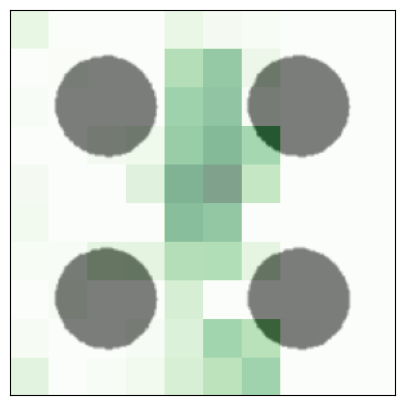

Occlusion tensor(0, device='cuda:0') circle 1.0
efficientnet_v2_s


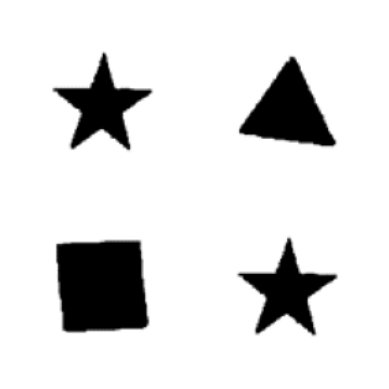

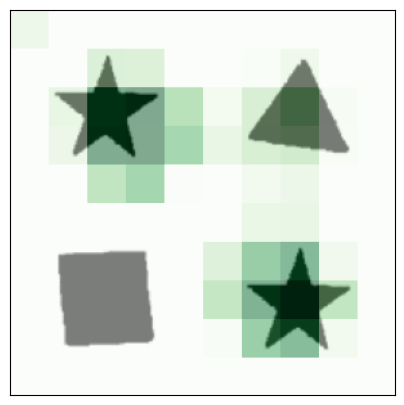

GradCam 2 star 1.0


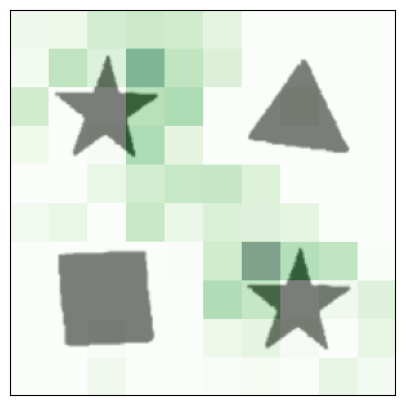

Occlusion tensor(2, device='cuda:0') star 1.0
efficientnet_v2_s


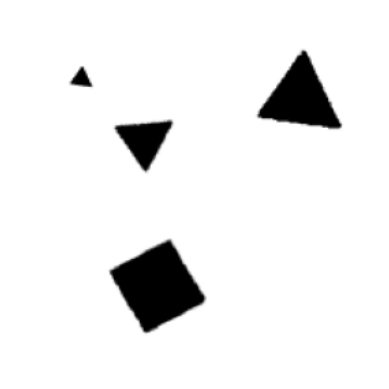

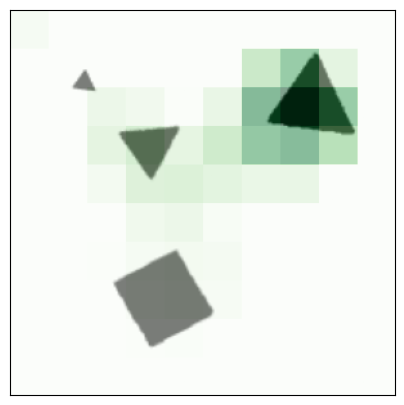

GradCam 3 triangle 0.97


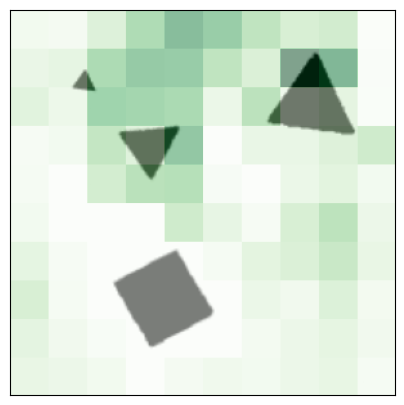

Occlusion tensor(3, device='cuda:0') triangle 0.97
efficientnet_v2_s


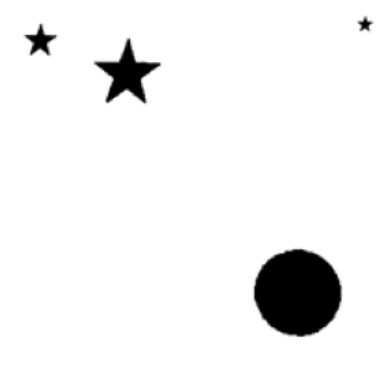

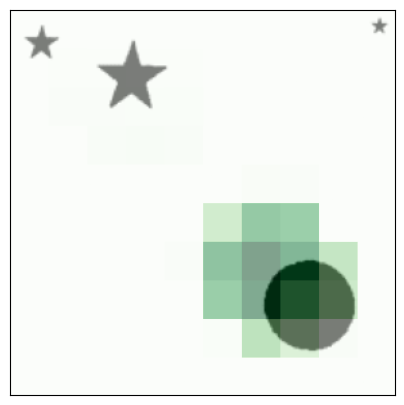

GradCam 0 circle 0.74


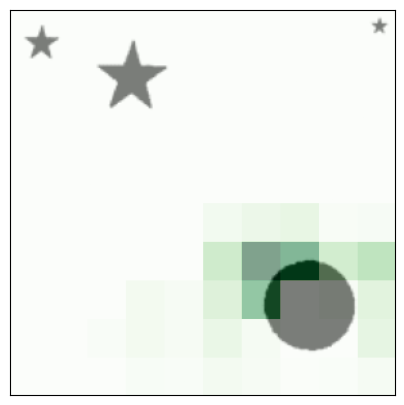

Occlusion tensor(0, device='cuda:0') circle 0.74
efficientnet_v2_s


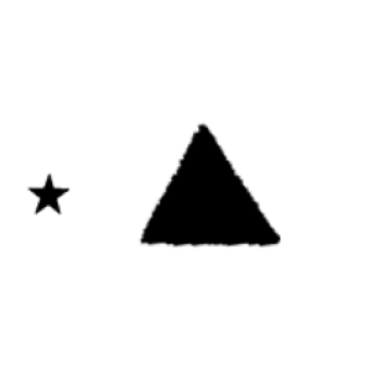

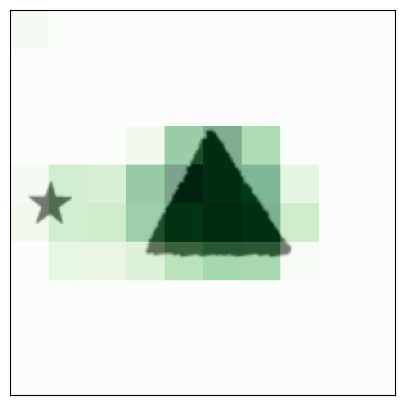

GradCam 3 triangle 0.99


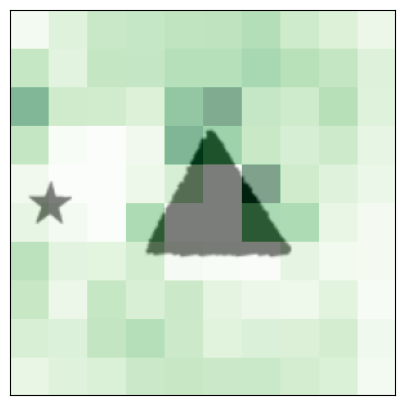

Occlusion tensor(3, device='cuda:0') triangle 0.99
efficientnet_v2_s


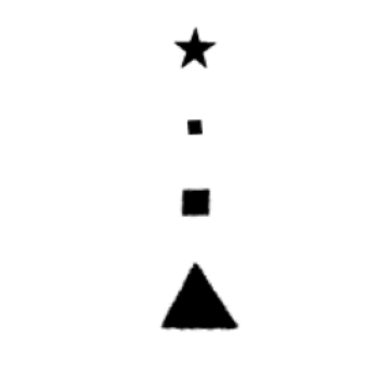

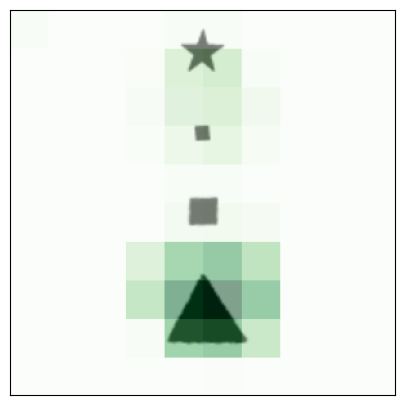

GradCam 3 triangle 0.87


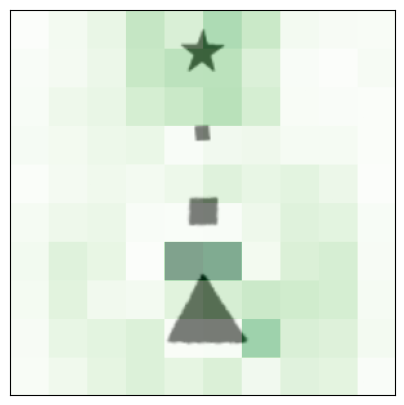

Occlusion tensor(3, device='cuda:0') triangle 0.87
generalisation/models/6ffe9788-8300-4727-997a-a1919c82d835_complete_model.pth : 6ffe9788-8300-4727-997a-a1919c82d835 : study3
efficientnet_v2_s


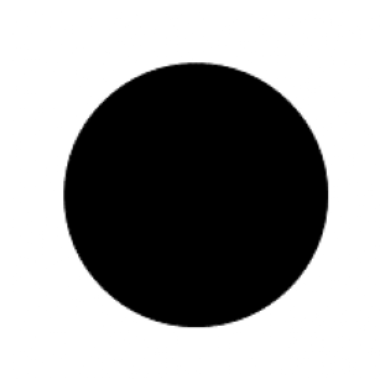

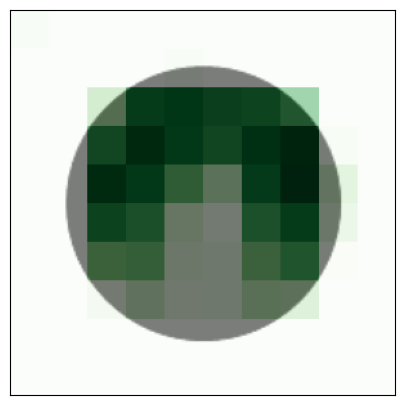

GradCam 0 circle 1.0


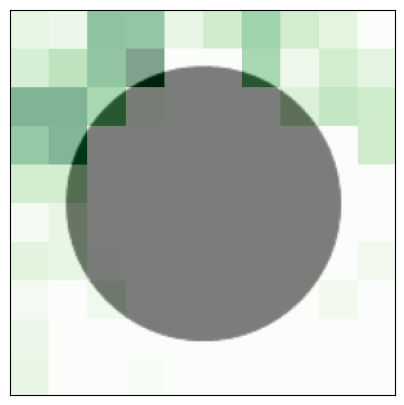

Occlusion tensor(0, device='cuda:0') circle 1.0
efficientnet_v2_s


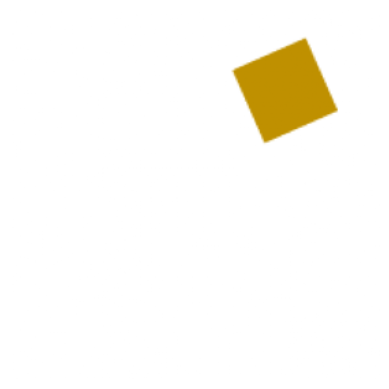

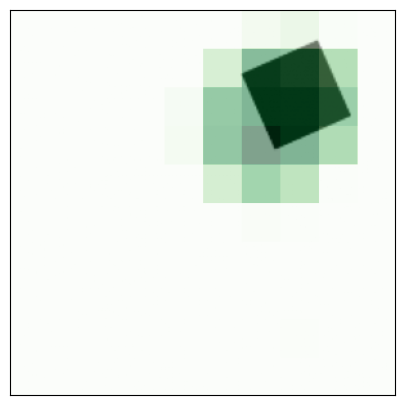

GradCam 1 square 1.0


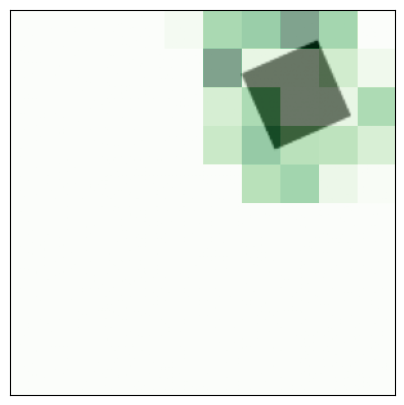

Occlusion tensor(1, device='cuda:0') square 1.0
efficientnet_v2_s


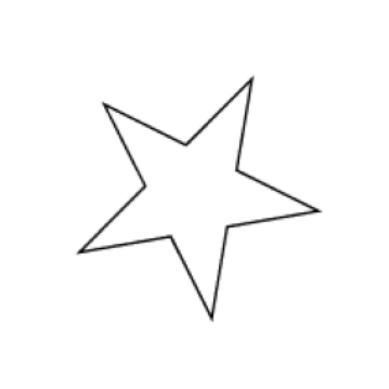

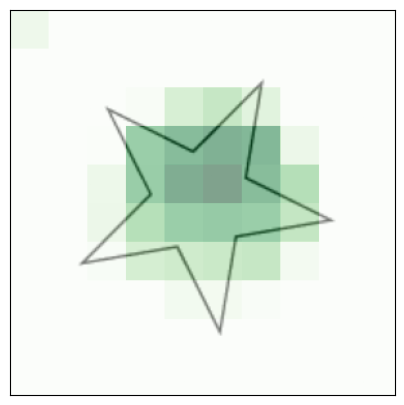

GradCam 2 star 0.99


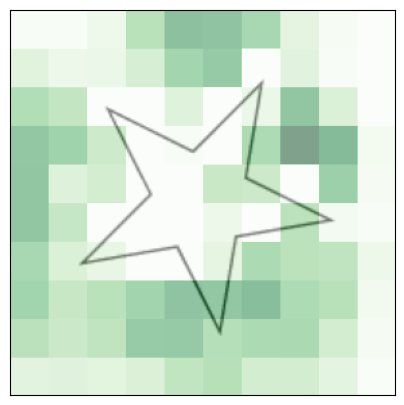

Occlusion tensor(2, device='cuda:0') star 0.99
efficientnet_v2_s


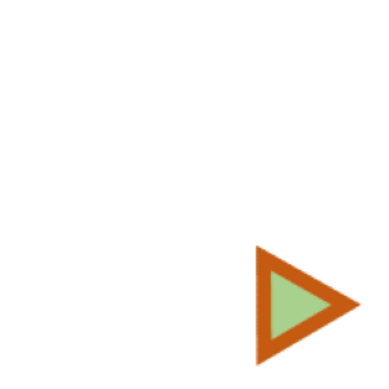

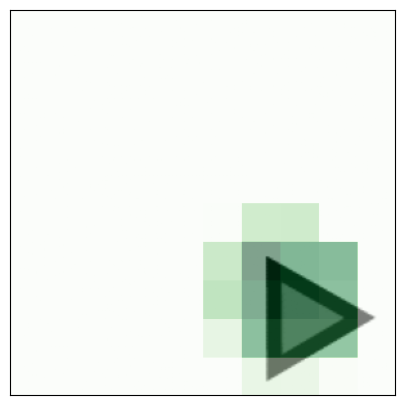

GradCam 3 triangle 0.99


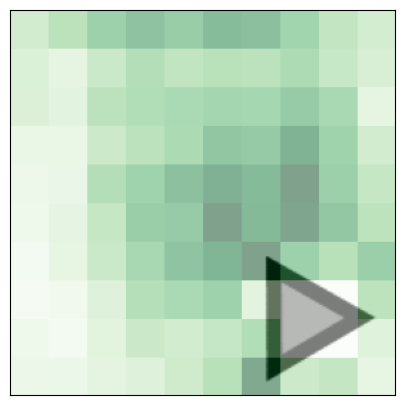

Occlusion tensor(3, device='cuda:0') triangle 0.99
efficientnet_v2_s


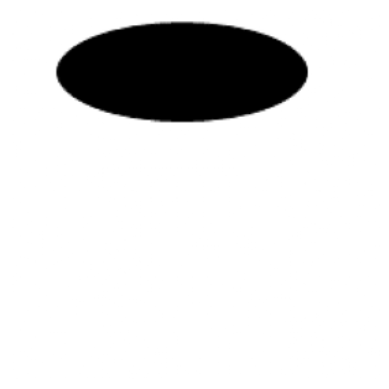

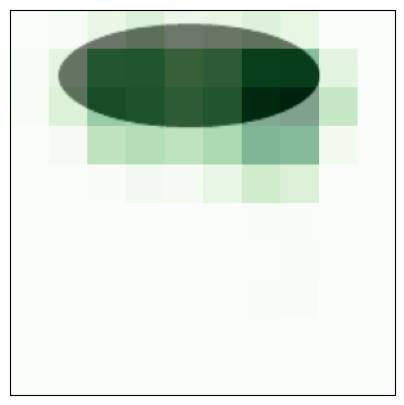

GradCam 0 circle 1.0


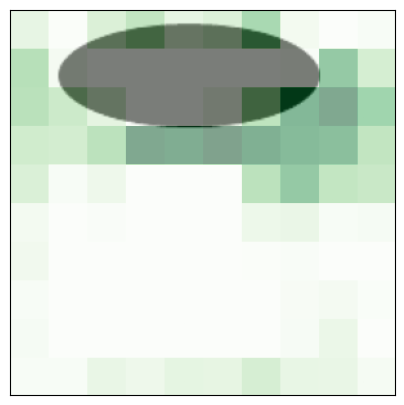

Occlusion tensor(0, device='cuda:0') circle 1.0
efficientnet_v2_s


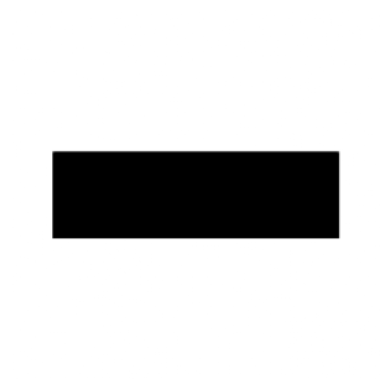

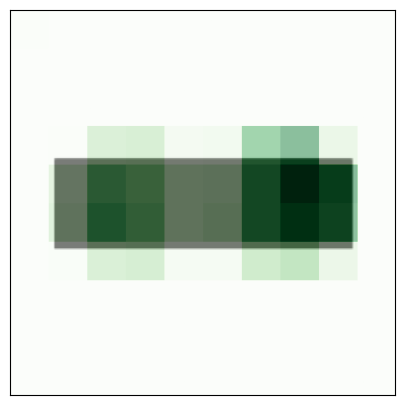

GradCam 1 square 0.94


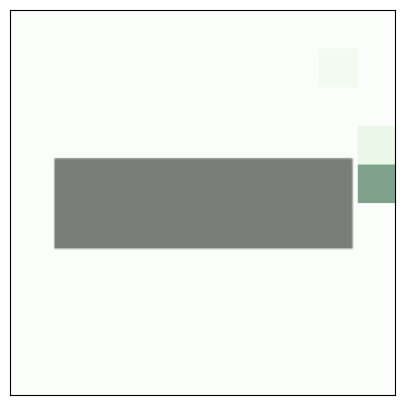

Occlusion tensor(1, device='cuda:0') square 0.94
efficientnet_v2_s


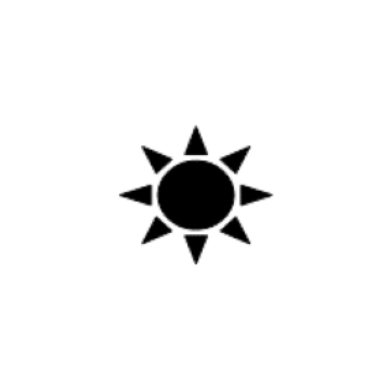

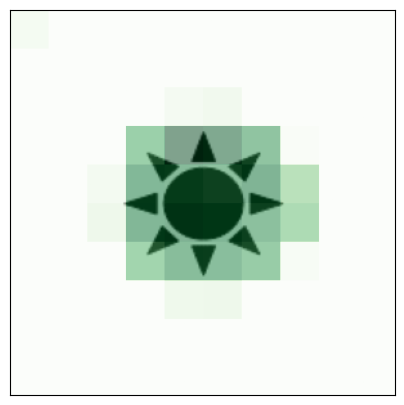

GradCam 2 star 1.0


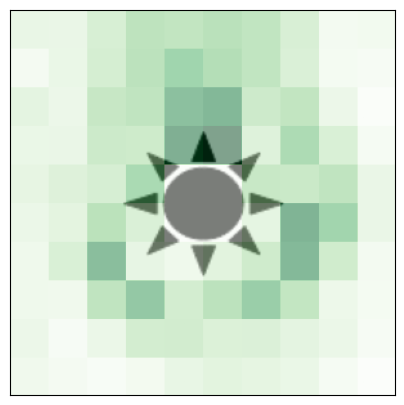

Occlusion tensor(2, device='cuda:0') star 1.0
efficientnet_v2_s


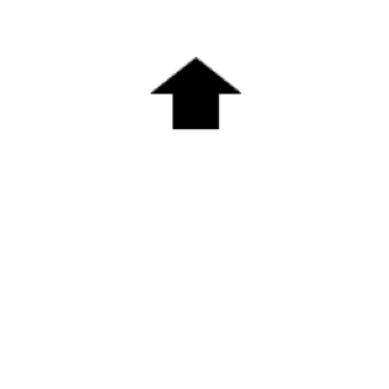

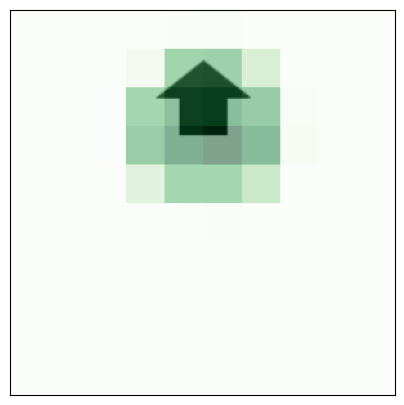

GradCam 1 square 0.99


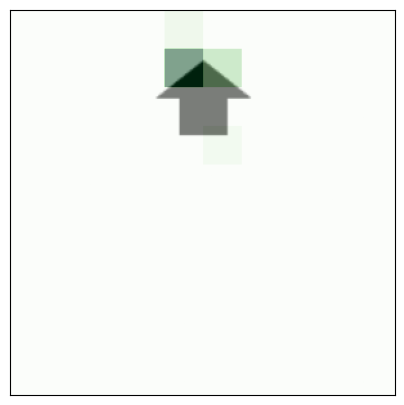

Occlusion tensor(1, device='cuda:0') square 0.99


In [12]:
#%%capture
models_path= "generalisation/models/"
save_path = 'models/'
testset_path = "testset/"
#Get models
trained_models=[]
ids = []
for id in models:
  d = join(models_path, id+"_complete_model.pth")
  if (isfile(d)):
    trained_models.append(d)
    ids.append(id)
#Get study folders
study_directories=[]
for name in os.listdir(testset_path):
    d = os.path.join(testset_path, name)
    if os.path.isdir(d):
      study_directories.append(name)
study_directories.sort()
#Ok run
for trained_model,id in zip(trained_models,ids):
  json_study = {}
  for testset_folder in study_directories:
    print(trained_model,":",id,":",testset_folder)
    model_ft= torch.load(trained_model, map_location=torch.device(device))
    model_ft.eval()
    model_ft = model_ft.to(device)
    json_study[testset_folder] = run_experiment_shapes(model_ft, testset_path+testset_folder, save_path, id+'/studies/'+testset_folder,  0)
  models[id]['studies'] = json_study
with open(save_path + 'models.json', 'w') as outfile:
  outfile.write(json.dumps(models))

In [13]:
zip_name = "saliency_maps"
shutil.make_archive(zip_name, 'zip', "models")

'/content/saliency_maps.zip'